# Sessa Empirical Estimator (SEE) Implementation in Python

## What is the Sessa Empirical Estimator (SEE)?

The Sessa Empirical Estimator (SEE) is a statistical method used for analyzing event-driven data, particularly in the context of healthcare, epidemiology, and time-series analysis. It is designed to estimate the underlying patterns of event occurrences by utilizing empirical cumulative distribution functions (ECDF) and density estimation techniques. SEE is particularly useful for identifying clustering patterns in event intervals, which can help in understanding patient behavior, treatment adherence, or disease progression.

At its core, SEE begins by preprocessing event data, typically timestamps associated with patient visits, medical events, or transactions. The method calculates the time intervals between consecutive events and applies statistical transformations such as logarithmic scaling to normalize the data. An essential step in SEE is the use of ECDF, which provides a non-parametric estimate of the probability distribution of event intervals. The ECDF helps in visualizing the proportion of intervals falling below a certain threshold, aiding in trend identification.

Density estimation techniques, such as Gaussian kernel density estimation, are then applied to smooth out variations in the data and reveal underlying patterns. Clustering algorithms, such as K-Means or DBSCAN, are integrated into SEE to group events with similar interval patterns, allowing for a deeper understanding of temporal structures. K-Means assigns events into predefined clusters based on similarity, while DBSCAN detects naturally occurring dense regions in the data without requiring a fixed number of clusters.

SEE is widely used in real-world applications such as medical event analysis, patient adherence studies, and fraud detection. By leveraging clustering and density estimation, SEE provides actionable insights that help researchers and practitioners make data-driven decisions based on event patterns. Its flexibility and adaptability make it a powerful tool for analyzing time-dependent data in various fields.

### Application of SEE in Your Code:
- The ECDF function (ecdf() and plot_ecdf()) computes and visualizes event intervals.
- The clustering methods (kmeans_clustering() and dbscan_clustering()) segment event intervals into meaningful groups.
- The density estimation function (plot_density()) analyzes the underlying data distribution.
- Histograms and Boxplots (plot_clusters()) compare cluster behaviors.

## Comparison of DBSCAN vs. K-Means Clustering using the Sessa Empirical Estimator (SEE)

### K-Means Clustering in SEE
K-Means clustering, when applied within the Sessa Empirical Estimator (SEE), partitions event interval data into a predefined number of clusters by minimizing intra-cluster variance. The method operates by iteratively assigning data points to centroids and updating the centroids until convergence is reached. In SEE, K-Means is particularly effective when the event intervals exhibit clear, well-separated groupings. It allows for an interpretable segmentation of patient event intervals, helping identify trends such as frequent or infrequent event occurrences. However, K-Means assumes that clusters are spherical and evenly sized, which may not always be the case in real-world event-driven data. Additionally, the need to predefine the number of clusters (k) can lead to arbitrary selections, impacting the accuracy of the clustering outcome. Despite these limitations, K-Means provides a structured approach to event segmentation and is useful for scenarios where distinct temporal patterns exist.

### DBSCAN Clustering in SEE
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) operates differently from K-Means by identifying dense regions of data and labeling points outside these regions as noise. In the context of SEE, DBSCAN is advantageous because it does not require specifying the number of clusters beforehand and can detect clusters of varying shapes and densities. This flexibility makes it well-suited for analyzing medical event intervals, where clusters may not be evenly distributed. DBSCAN effectively captures irregular event patterns, highlighting groups with frequent occurrences while filtering out outliers. However, selecting an optimal epsilon (ε) value for neighborhood density can be challenging and dataset-dependent. Unlike K-Means, DBSCAN may classify a significant portion of data as noise if the clustering parameters are not well-tuned. Nonetheless, its ability to uncover hidden structures in complex event-driven datasets makes it a valuable tool in SEE-based clustering.

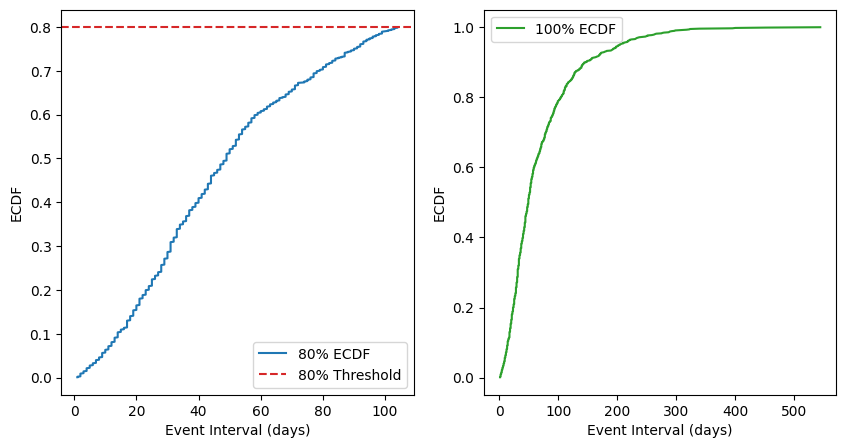

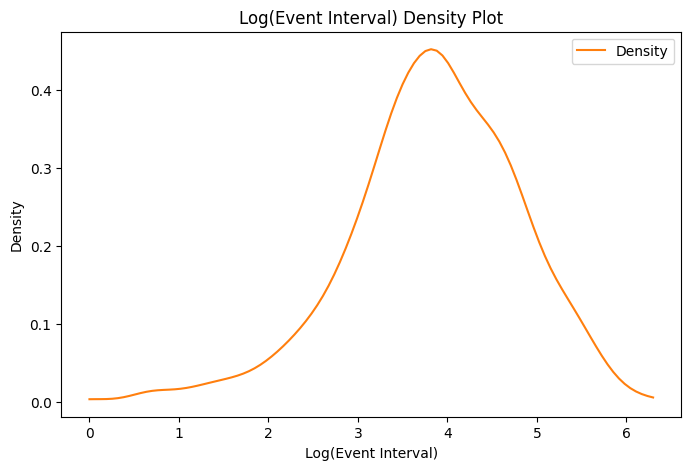

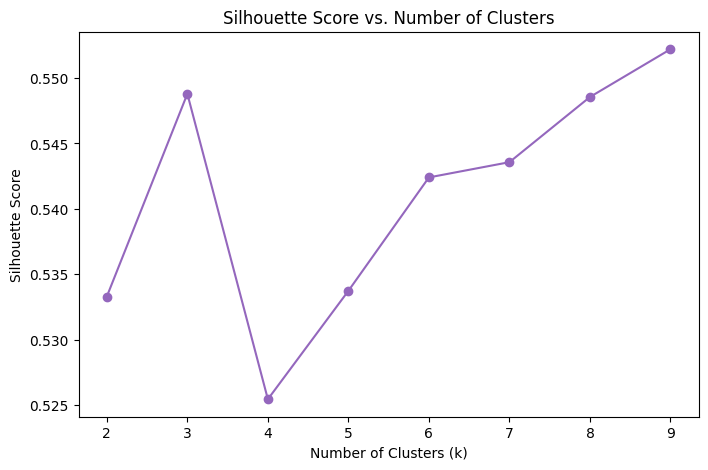

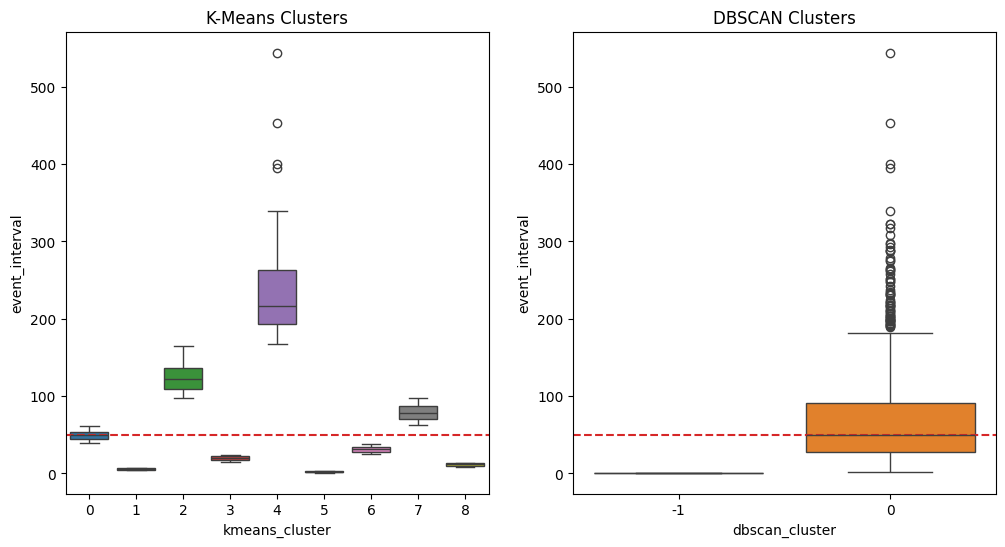

In [3]:
# LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import warnings

warnings.simplefilter("always")
warnings.filterwarnings(
        "ignore",
        category=PendingDeprecationWarning)

# FUNCTIONS
def load_data(file_path):
    """Loads the dataset and renames columns."""
    data = pd.read_csv(file_path)
    data.rename(columns={'DATE': 'eksd', 'PATIENT_ID': 'pnr'}, inplace=True)
    return data

def preprocess_data(data):
    """Preprocesses data by converting dates and calculating event intervals."""
    data['eksd'] = pd.to_datetime(data['eksd'])
    data = data.sort_values(by=['pnr', 'eksd'])
    data['prev_eksd'] = data.groupby('pnr')['eksd'].shift(1)
    data = data.dropna()
    data['event_interval'] = (data['eksd'] - data['prev_eksd']).dt.days
    return data[data['event_interval'] > 0]

def ecdf(data):
    """Computes the empirical cumulative distribution function."""
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

def plot_ecdf(data):
    """Plots the ECDF for event intervals."""
    x, y = ecdf(data['event_interval'])
    df_ecdf = pd.DataFrame({'x': x, 'y': y})
    df_ecdf = df_ecdf[df_ecdf['y'] <= 0.8]

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(df_ecdf['x'], df_ecdf['y'], label='80% ECDF', color='tab:blue')  # Changed color
    plt.axhline(y=0.8, linestyle='dashed', color='tab:red', label='80% Threshold')  # Changed color
    plt.xlabel("Event Interval (days)")
    plt.ylabel("ECDF")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, y, label='100% ECDF', color='tab:green')  # Changed color
    plt.xlabel("Event Interval (days)")
    plt.ylabel("ECDF")
    plt.legend()
    
    plt.show()

def plot_density(data):
    """Plots the density estimation for log-transformed event intervals."""
    density = gaussian_kde(np.log(data['event_interval']))
    x_vals = np.linspace(min(np.log(data['event_interval'])), max(np.log(data['event_interval'])), 100)
    y_vals = density(x_vals)

    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, y_vals, label="Density", color='tab:orange')  # Changed color
    plt.title("Log(Event Interval) Density Plot")
    plt.xlabel("Log(Event Interval)")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

def kmeans_clustering(data):
    """Performs K-Means clustering and selects the optimal number of clusters using silhouette score."""
    scaled_data = np.log(data[['event_interval']])
    sil_scores = {}

    for k in range(2, 10):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(scaled_data)
        score = silhouette_score(scaled_data, kmeans.labels_)
        sil_scores[k] = score
    
    plot_silhouette_scores(sil_scores)
    
    optimal_k = max(sil_scores, key=sil_scores.get)
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10).fit(scaled_data)
    data['kmeans_cluster'] = kmeans.labels_
    
    return data

def plot_silhouette_scores(sil_scores):
    """Plots silhouette scores for different cluster sizes."""
    plt.figure(figsize=(8, 5))
    plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o', linestyle='-', color='tab:purple')  # Changed color
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score vs. Number of Clusters")
    plt.show()

def dbscan_clustering(data):
    """Performs DBSCAN clustering and finds optimal eps value using nearest neighbors."""
    scaled_data = np.log(data[['event_interval']])

    # Determine optimal epsilon
    neighbors = NearestNeighbors(n_neighbors=5)
    neighbors_fit = neighbors.fit(scaled_data)
    distances, indices = neighbors_fit.kneighbors(scaled_data)
    distances = np.sort(distances[:, -1])
    
    eps_value = 0.5  # Default value (adjustable based on data)
    
    dbscan = DBSCAN(eps=eps_value, min_samples=5)
    data['dbscan_cluster'] = dbscan.fit_predict(scaled_data)
    
    return data

def plot_clusters(data):
    """Plots boxplots of event intervals for K-Means and DBSCAN clusters."""
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.boxplot(x='kmeans_cluster', y='event_interval', data=data, hue='kmeans_cluster', palette="tab10", legend=False)
    plt.axhline(y=np.median(data['event_interval']), linestyle='dashed', color='tab:red', label='Median')
    plt.title("K-Means Clusters")
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x='dbscan_cluster', y='event_interval', data=data, hue='dbscan_cluster', palette="tab10", legend=False)
    plt.axhline(y=np.median(data['event_interval']), linestyle='dashed', color='tab:red', label='Median')
    plt.title("DBSCAN Clusters")
    
    plt.show()

# MAIN FUNCTION
def main():
    """Main function to run the SEE process."""
    file_path = 'med_events.csv'
    data = load_data(file_path)
    data = preprocess_data(data)
    
    plot_ecdf(data)
    plot_density(data)
    
    data = kmeans_clustering(data)
    data = dbscan_clustering(data)
    
    plot_clusters(data)

if __name__ == "__main__":
    main()


### Figure 1: Empirical Cumulative Distribution Function (ECDF)
The left plot shows the ECDF for event intervals up to the 80% threshold, with a red dashed line indicating where 80% of the data lies. The right plot presents the full ECDF up to 100%. This visualization helps determine the distribution of event intervals, showing that most events occur within shorter time spans. The 80% threshold provides a useful benchmark for clustering analysis.

### Figure 2: Log(Event Interval) Density Plot
This density plot represents the distribution of event intervals in logarithmic scale. The peak of the density curve suggests that a majority of event intervals fall within a specific range. This transformation helps in clustering since event intervals span a wide range, and log-scaling makes the distribution more suitable for distance-based clustering methods like K-Means and DBSCAN.

### Figure 3: Silhouette Score vs. Number of Clusters
This figure evaluates the optimal number of clusters for K-Means using silhouette scores. The silhouette score measures cluster quality, with higher values indicating better-defined clusters. The peak at k=3 suggests that three clusters might be optimal, but the upward trend at k=9 indicates potential improvements with more clusters. This result influences the K-Means clustering choice.

### Figure 4: K-Means vs. DBSCAN Clustering
The left boxplot shows the K-Means clusters, highlighting different groups based on event intervals. Clusters with higher median values represent patients with longer event intervals. The right boxplot displays DBSCAN clusters, where "-1" represents noise points (outliers) that were not assigned to any cluster. DBSCAN forms a single dense cluster while marking outliers, contrasting with K-Means, which forces all points into clusters.

## CONLUSION
K-Means creates distinct clusters based on event intervals, with larger gaps between them. It is effective when clear cluster centers exist but struggles with noise and outliers. DBSCAN focuses on density, grouping points based on proximity while identifying outliers. It is more flexible but can result in fewer distinct clusters. K-Means provides structured clustering, while DBSCAN allows for better anomaly detection. The choice between the two depends on whether the goal is to form well-separated groups (K-Means) or detect anomalies and dense regions (DBSCAN).